In [44]:
%load_ext autoreload
%autoreload 2

from tqdm.notebook import tqdm
from tqdm.auto import trange
import itertools as it
import h5py
from copy import deepcopy

import numpy as np
import cvxpy as cp
import networkx as nx
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch_geometric.utils import dense_to_sparse

from sca import *
from utils import *
from models_uf import *


## load data

In [130]:
dfn3 = '../../data/results_hataUrban_noSF.h5'
X_tr, y_tr = [],[]
with h5py.File(dfn3, "r") as handle:
    print( handle['input']["channel_to_noise_matched"])
    print( type(handle['input']['PA inefficency'][...].item()))
    print( handle['input']['Pc'][...])

2020-12-23 23:02:19 | <HDF5 dataset "channel_to_noise_matched": shape (1000, 4, 4), type "<f4">
2020-12-23 23:02:19 | <class 'float'>
2020-12-23 23:02:19 | 1.0


In [45]:
#--- data---

num_ue = 4
mu = 4
Pc = 1

device = torch.device('cpu')

# # train data
# dfn3 = '../../data/dset%d.h5'%num_ue
# with h5py.File(dfn3, "r") as handle:
#     X_tr = handle['training']['input'][...]
#     y_tr = handle['training']['xopt'][...]
    
# # validation data
# dfn4 = '../../data/dset%d.h5'%num_ue
# with h5py.File(dfn4, "r") as handle:
#     X_va = handle['validation']['input'][...]
#     y_va = handle['validation']['xopt'][...]
      
        
#--- data---


# train data
dfn3 = '../../data/results_hataUrban_noSF.h5'
X_tr, y_tr = [],[]
with h5py.File(dfn3, "r") as handle:
    Hs = handle['input']["channel_to_noise_matched"]
    Plin = 10**(np.asarray(handle['input']['PdB'][...], dtype=np.float)/10)
    xopt = handle['xopt']
    
    assert num_ue==Hs.shape[1]

    for hidx in trange(Hs.shape[0]):
        edge_index_tr, h = dense_to_sparse(torch.from_numpy(Hs[hidx].astype(float)))
        x1 = (h.reshape((-1,1))*Plin).T # -->(h1p1, h2p1, h3p1, ...)
        X_tr.append(np.hstack((x1, Plin.reshape(-1,1))))
        y_tr.append(xopt[hidx,...] )                   

y_tr = np.concatenate((y_tr))
X_tr = np.concatenate((X_tr))
y_tr = y_tr[~np.any(np.isnan(X_tr),-1)]     
X_tr = X_tr[~np.any(np.isnan(X_tr),-1)]


# validation data
dfn4 = '../../data/results_hataUrban.h5'
X_va, y_va = [],[]
with h5py.File(dfn4, "r") as handle:
    Hs = handle['input']["channel_to_noise_matched"]
    Plin = 10**(np.asarray(handle['input']['PdB'][...], dtype=np.float)/10)
    xopt = handle['xopt']
    
    for hidx in trange(Hs.shape[0]):
        edge_index_va, h = dense_to_sparse(torch.from_numpy(Hs[hidx].astype(float)))
        x1 = (h.reshape((-1,1))*Plin).T # -->(h1p1, h2p1, h3p1, ...)
        X_va.append(np.hstack((x1, Plin.reshape(-1,1))))
        y_va.append(xopt[hidx,...] )

y_va = np.concatenate((y_va))
X_va = np.concatenate((X_va))
y_va = y_va[~np.any(np.isnan(X_va),-1)]     
X_va = X_va[~np.any(np.isnan(X_va),-1)]

        
#--- (end)---

        
# to torch tensor
y_tr = torch.from_numpy(y_tr).float().to(device)
y_va = torch.from_numpy(y_va).float().to(device)

print(X_tr.shape, y_tr.shape)
print(X_va.shape, y_va.shape)



2020-12-27 17:41:17 | (51000, 17) torch.Size([51000, 4])
2020-12-27 17:41:17 | (51000, 17) torch.Size([51000, 4])


Text(0.5, 1.0, 'Test allocation histogram')

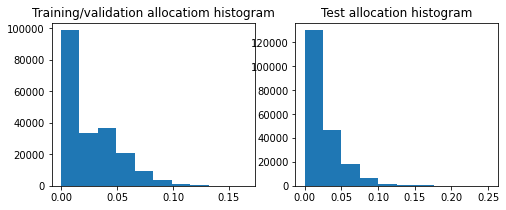

In [133]:
torch.cuda.empty_cache()
plt.figure(figsize=(8,3))
plt.subplot(121)
plt.hist(y_tr.numpy().flatten())
plt.title('Training/validation allocatiom histogram')
plt.subplot(122)
plt.hist(y_va.numpy().flatten())
plt.title('Test allocation histogram')

In [42]:
[i for i in [1,2,4]]

[1, 2, 4]

## unfolded sca pipeline

In [135]:

in_size = num_ue**2 + num_ue + 1
out_size = num_ue

h_sizes = [128, 64, 32, 32, 32, 16, 8]
activs = ['elu', 'relu', 'elu', 'relu', 'elu', 'relu',  'elu']

k_fold = 2
bs = 512
num_l = 3 # 1 2 3
nepochs = 200
learning_rate = 0.001#001

init = 'full'
rseed= 42
loss_which= ['mse','wsee']
architecture = USCA_MLP_R # USCA_MLP
inner_optim='learned-mlp' 

mstr = architecture.__name__.replace('_','.')+'+'+inner_optim.replace('-','.')
fix='%s_kf+%d_bs+%d_nl+%d_lr+%2e_pinit+%s_loss+%s_rseed+%d'%(
    mstr, k_fold, bs, num_l, learning_rate, init, '+'.join(loss_which), rseed)


import numpy as np
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=k_fold, shuffle=True, random_state=rseed)
tr_loss, va_loss, te_loss = {},{},{}
tr_wsee, va_wsee, te_wsee = {},{},{}
tr_wsee_opt, va_wsee_opt, te_wsee_opt = {},{},{}

# add initial pt (max)
X_tr_ = torch.from_numpy(np.hstack((init_p(X_tr[:,-1], num_ue, method=init), X_tr))).float().to(device)
X_va_ = torch.from_numpy(np.hstack((init_p(X_va[:,-1], num_ue, method=init), X_va))).float().to(device)

for k, (train_index, valid_index) in enumerate(skf.split(X_tr, np.asarray([True]*y_tr.shape[0]))):
    # k fold cross validation
    
    X_train, y_train = X_tr_[train_index], y_tr[train_index]
    X_valid, y_valid = X_tr_[valid_index], y_tr[valid_index]
    X_test, y_test   = X_va_[valid_index], y_va[valid_index]
    
#     raise
    
    print(X_train.shape, X_valid.shape, y_train.shape, y_valid.shape)
    
    tr_loss[k], va_loss[k], te_loss[k] = [],[],[]
    tr_wsee[k], va_wsee[k], te_wsee[k] = [],[],[]
    tr_wsee_opt[k] = f_wsee_torch(y_train, X_train, mu, Pc, 'mean').item()
    va_wsee_opt[k] = f_wsee_torch(y_valid, X_valid, mu, Pc, 'mean').item()
    te_wsee_opt[k] = f_wsee_torch(y_test, X_test, mu, Pc, 'mean').item()
    
    print('%d-fold: train opt wsee %.6f / val opt wsee %.6f / test opt wsee %.6f'%(
            k, tr_wsee_opt[k], va_wsee_opt[k], te_wsee_opt[k]))
    
    model = architecture(num_l, in_size, out_size, h_sizes, activs=activs, channel_info={'mu':mu, 'Pc':Pc},
                     dropout=0, inner_optim=inner_optim).to(device)
    opt = torch.optim.Adam(model.parameters(), lr=learning_rate)
#     opt = torch.optim.SGD(model.parameters(), lr=learning_rate)
    
    count_parameters(model)
    
    for epoch in trange(nepochs, desc='%d-th fold:'%(k+1)):
        model.train()
        perm_i = np.random.permutation(y_train.shape[0])

        running_loss, running_wsee = 0,0
        for i in range(len(perm_i)//bs):
#             print(i,end='\r')

            i_s, i_e = i*bs, (i+1)*bs

            y_true = y_train[i_s:i_e]
            x = X_train[i_s:i_e]

            y_pred, gamma = model(x)
#             print(y_pred)

            
            mse = torch.mean((y_pred-y_true)**2, dim=0)
            wsee = f_wsee_torch(y_pred, x, mu, Pc, 'vector')

            loss = 0
            if 'mse' in loss_which:
                loss += mse
            if 'wsee' in loss_which:
                loss -= wsee
                
            opt.zero_grad()
            loss.backward(torch.ones(num_ue).to(device)) #vector loss
        
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
            opt.step()    

            running_loss += torch.mean(mse).item()
            running_wsee += torch.mean(wsee).item()

#             if not i%100:
#                 print('%d:%d/%d'%(epoch,i,y_tr.shape[0]), torch.mean(loss).item())
        tr_loss[k].append(running_loss/(i+1))
        tr_wsee[k].append(running_wsee/(i+1)*num_ue)

        model.eval()
        # validation
        yp_valid, gamma = model( X_valid )        
        vloss = torch.mean((yp_valid-y_valid)**2).item()
        vobj = f_wsee_torch(yp_valid, X_valid, mu, Pc, 'mean').item()
        va_loss[k].append(vloss) 
        va_wsee[k].append(vobj) 

        # test
        yp_test, gamma = model( X_test )
        tloss = torch.mean((yp_test-y_test)**2).item()
        tobj = f_wsee_torch(yp_test, X_test, mu, Pc, 'mean').item()
        te_loss[k].append(tloss) 
        te_wsee[k].append(tobj)      

        print('%d: train loss %.6f / val loss %.6f / test loss %.6f'%(
            epoch, tr_loss[k][-1], va_loss[k][-1], te_loss[k][-1]))
        print('%d: train wsee %.6f / val wsee %.6f / test wsee %.6f'%(
            epoch, tr_wsee[k][-1], va_wsee[k][-1], te_wsee[k][-1])) 
        print()
        
#     break




2020-12-24 04:34:10 | torch.Size([25500, 21]) torch.Size([25500, 21]) torch.Size([25500, 4]) torch.Size([25500, 4])
2020-12-24 04:34:10 | 0-fold: train opt wsee 7.876275 / val opt wsee 7.827026 / test opt wsee 9.227342


2020-12-24 04:34:11 | 0: train loss 0.811207 / val loss 0.442298 / test loss 0.828272
2020-12-24 04:34:11 | 0: train wsee 5.079382 / val wsee 5.706871 / test wsee 6.209196
2020-12-24 04:34:11 | 
2020-12-24 04:34:11 | 1: train loss 0.238009 / val loss 0.093517 / test loss 0.191886
2020-12-24 04:34:11 | 1: train wsee 5.645555 / val wsee 5.696015 / test wsee 5.961827
2020-12-24 04:34:11 | 
2020-12-24 04:34:12 | 2: train loss 0.156488 / val loss 0.036801 / test loss 0.050996
2020-12-24 04:34:12 | 2: train wsee 5.978916 / val wsee 6.119485 / test wsee 6.493530
2020-12-24 04:34:12 | 
2020-12-24 04:34:13 | 3: train loss 0.095766 / val loss 0.011591 / test loss 0.013991
2020-12-24 04:34:13 | 3: train wsee 6.441408 / val wsee 7.010986 / test wsee 7.941950
2020-12-24 04:34:13 | 
2020-12-24 04:34:13 | 4: train loss 0.075442 / val loss 0.000569 / test loss 0.000681
2020-12-24 04:34:13 | 4: train wsee 7.291217 / val wsee 7.422494 / test wsee 8.415025
2020-12-24 04:34:13 | 
2020-12-24 04:34:14 | 5: 

KeyboardInterrupt: 

In [55]:
import json

list_to_save = ['tr_loss', 'va_loss', 'te_loss', 'tr_wsee', 'va_wsee', 'te_wsee']

with open('./results/%s.json'%fix, 'w') as fp:
    evals = {'tr_loss':tr_loss, 'va_loss':va_loss, 'te_loss':te_loss, 
             'tr_wsee':tr_wsee, 'va_wsee':va_wsee, 'te_wsee':te_wsee}
    json.dump(evals, fp)


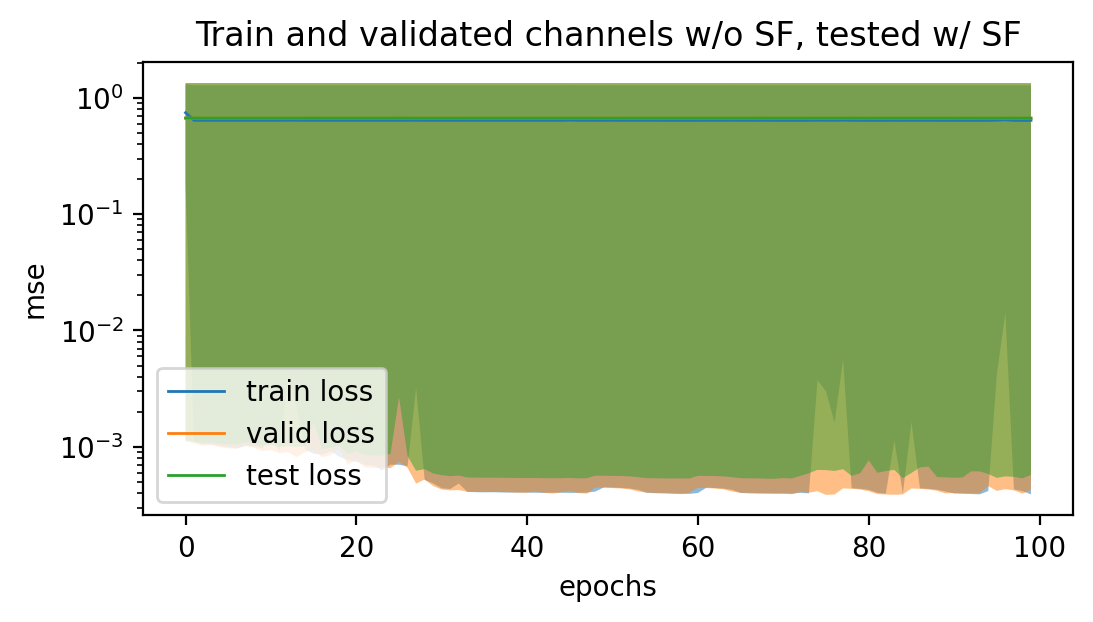

In [56]:

plt.figure(figsize=(6,3),  dpi=200)

for ph, loss in zip(["train", "valid", "test"],[tr_loss, va_loss, te_loss]):

    m = np.mean(list(loss.values()),0)
    e = np.std(list(loss.values()),0)

    plt.plot(range(epoch+1), m, '-', linewidth=1, label='%s loss'%ph)
    plt.fill_between(range(epoch+1), m-e, m+e,
        alpha=.5, #edgecolor='#3F7F4C', facecolor='#7EFF99',
        linewidth=0, label=None)

plt.xlabel('epochs')
plt.ylabel('mse')
plt.legend()

plt.yscale('log')
# plt.xscale('log')
plt.title('Train and validated channels w/o SF, tested w/ SF')

plt.show()

In [150]:
torch.cuda.empty_cache()

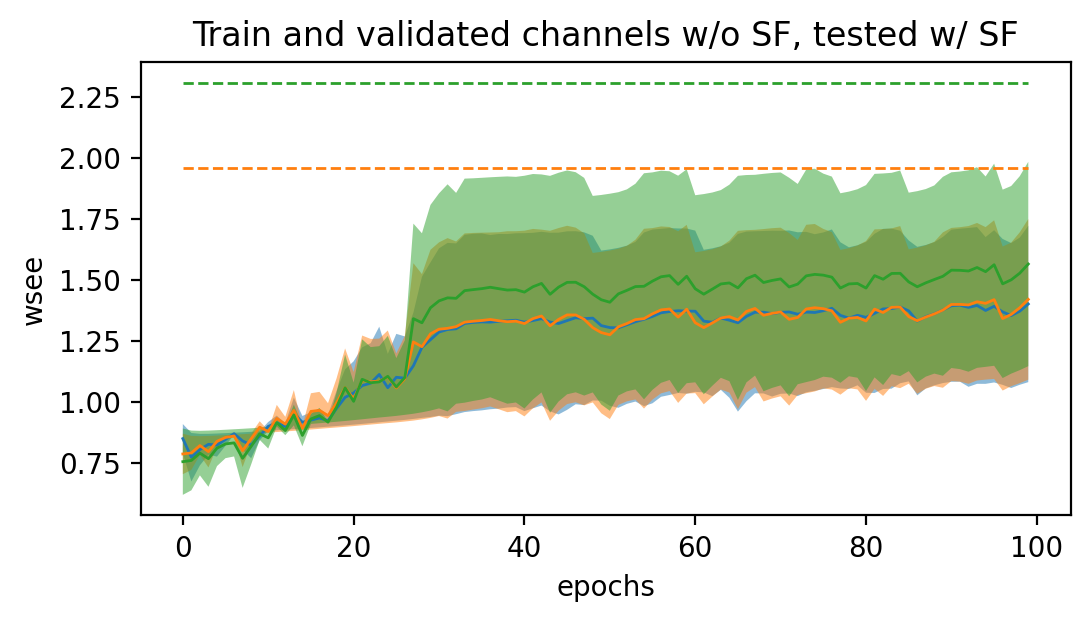

In [59]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

plt.figure(figsize=(6,3),  dpi=200)

for i, (ph, loss) in enumerate(zip(["train", "valid", "test"],[tr_wsee, va_wsee, te_wsee])):

#     plt.plot(range(epoch+1), list(loss.values())[1], '-', linewidth=1, label='%s wsee'%ph, color=colors[i])
    m = np.mean(list(loss.values()),0)
    e = np.std(list(loss.values()),0)

    plt.plot(range(epoch+1), m, '-', linewidth=1, label='%s wsee'%ph, color=colors[i])
    plt.fill_between(range(epoch+1), m-e, m+e,
        alpha=.5, #edgecolor='#3F7F4C', facecolor='#7EFF99',
        linewidth=0, label=None)

plt.plot([0, epoch], [va_wsee_opt[0]]*2, '--', linewidth=1, label='val/train wsee (opt)',color=colors[1])
plt.plot([0, epoch], [te_wsee_opt[0]]*2, '--', linewidth=1, label='test opt wsee (opt)',color=colors[2])



plt.xlabel('epochs')
plt.ylabel('wsee')
# plt.legend()

# plt.yscale('log')
# plt.xscale('log')
plt.title('Train and validated channels w/o SF, tested w/ SF')

plt.show()

In [ ]:
y_va, torch.from_numpy(y_va).float()

In [ ]:
Plin, xopt

In [74]:
#--- data---

num_ue = 4
mu = 4
Pc = 1

device = torch.device('cuda')


dfn4 = '../../data/results_hataUrban.h5'
with h5py.File(dfn4, "r") as handle:
    print(handle['input']['Channels'])
    raise
    Hs = handle['input']["channel_to_noise_matched"]
    Plin = 10**(np.asarray(handle['input']['PdB'][...], dtype=np.float)/10)
    xopt = handle['xopt']
    print(xopt.shape)
    

#--- (end)---

        
print(X_tr.shape, y_tr.shape)
print(X_va.shape, y_va.shape)


<HDF5 dataset "Channels": shape (1000, 4, 4, 2), type "<c8">


RuntimeError: No active exception to reraise

In [6]:
# X_train --> p0, Hs, Pmax; Pc, mu

n, d = X_valid.shape
nue = np.floor(d**.5).astype(int)
print(d, nue)
assert nue**2+nue+1 == d

p0_valid = X_valid[:, :nue].numpy()
hs_valid = X_valid[:, nue:-1].view(-1, nue, nue).numpy()
pmax_valid = X_valid[:, -1].numpy()

eeval2 = []
for ni in trange(n):
    p0 = p0_valid[ni]
    p = pmax_valid[ni]
    h = hs_valid[ni]/p
    
    y = y_valid[ni].numpy()

    eeval2.append(f_wsee(y, h, mu, Pc ))
    
print(np.mean(eeval2))
print(f_wsee_torch(y_valid, X_valid, mu, Pc, 'mean'))

21 4



7.8270745
tensor(7.8270)


## classical SCA

In [34]:
from copy import deepcopy

n, d = X_valid.shape
nue = np.floor(d**.5).astype(int)
print(d, nue)
assert nue**2+nue+1 == d

xx = deepcopy(X_valid)

p0_valid = xx[:, :nue].numpy()
hs_valid = xx[:, nue:-1].view(-1, nue, nue).numpy()
pmax_valid = xx[:, -1].numpy()

eeval = []
for ni in trange(n):
    if 1:#not ni or pmax_valid[ni-1] > pmax_valid[ni]:
        p0 = p0_valid[ni]
    else:
        p0 = P[-1]
    p = pmax_valid[ni]
    h = hs_valid[ni]/p
    
    O, P = SCA(h, mu = mu, Pc = Pc, Pmax = p, pt = p0, 
               SolverMaxIter = 100, MaxIter = 100, 
               parm_alpha = 1e-8, parm_beta = 0.01, 
               RelTolFun = 1e-12, RelTolVal = 1e-12,
               InnerOpt='sgd')
    if np.isnan(O[-1]):
        P[-1] = p0_valid[ni]
        O[-1] = f_wsee(P[-1], h, mu, Pc)
        
    if np.isnan(O[-1]):
        raise
        
    eeval.append(O[-1])
#     print(O[-1], P[-1])

21 4


[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
[nan nan nan nan]



RuntimeError: No active exception to reraise

In [35]:
np.nanmean(eeval)

5.611654

In [33]:
np.isnan(eeval).sum()

0

In [22]:

num_ue = 4
mu = 4
Pc = 1

INITS = ['last','full']#,'rand']
OPTIM = ['sgd', 'cvx']

INNER_MAXIT = [6]#, 2, 5, 10, 15, 20, 35, 50, 100, 150, 200]
# outer_maxit = [1, 2, 5, 10, 20, 50, 150]

log_outiters = dict(zip(INITS,[[] for _ in INITS]))
log_all = dict(zip(OPTIM,[[] for _ in OPTIM]))

for opt in OPTIM:
    
    for im in INNER_MAXIT:

        log_monitor = {
            'objective':dict(zip(INITS,[[] for _ in INITS])),
            'pwr_alloc':dict(zip(INITS,[[] for _ in INITS]))
        }


        dfn1 = '../../data/wsee%d-processed.h5'%num_ue
        with h5py.File(dfn1, "r") as f:
            PdB = f['input']['PdB'][...] # this is fixed

        assert np.allclose(PdB, np.array(range(-30,20+1,1)))
        Plin = 10**(np.asarray(PdB/10))

        dfn2 = '../../data_my/channels-%d.h5'%num_ue
    #     dfn2 = '../../data_my/channels-HataSuburban-%d.h5'%num_ue
        with h5py.File(dfn2, "r") as f:
            # Get the data
            data = {k:{kk: v[:] for kk,v in f[k].items()} for k in f.keys()}

            Hs = data['input']['channel_to_noise_matched']

            for hidx in tqdm([456]):#trange(Hs.shape[0]):#tqdm(np.random.permutation(Hs.shape[0])):

                h = Hs[hidx]
                pt = None

                p_perm = list(range(len(Plin)))#
                for pidx in tqdm(p_perm, desc=str(im)):

                    p = Plin[pidx]

                    O = dict(zip(INITS,[[] for _ in INITS]))
                    P = dict(zip(INITS,[[] for _ in INITS]))
                    
                    for istr in INITS: #['last','full']
                        if istr == 'last' and pt is not None:
                            p0 = pt
                        elif istr == 'full' or pt is None:
                            p0 = np.full(num_ue, p)
                        else:
                            raise NotImplemented
                            
                        try:
                            assert istr == 'last' # dont do full 
                            O[istr], P[istr] = SCA(h, mu, Pc, Pmax = p, pt = p0, 
                                                    SolverMaxIter=im, MaxIter = 1000, 
                                                    parm_alpha = 1e-8, parm_beta = 0.01, 
                                                    RelTolFun = 1e-12, RelTolVal = 1e-12, 
                                                    InnerOpt=opt)
                        except:
                            O[istr], P[istr] = [-np.inf], [np.full(num_ue, p)]
                            
                    # best init
                    bstr = max(O, key=lambda key: O[key][-1]) 
                    pt = P[bstr][-1]

                    print('%s init is best!'%bstr.upper(), 
                          '; objective ee =', O[bstr][-1], 
                          '; #outer iters =', len(O[bstr]),
                          '; pt =', pt, '; Pmax =', p)

                    [log_monitor['objective'][k].append(v) for k,v in O.items()]
                    [log_monitor['pwr_alloc'][k].append(v) for k,v in P.items()]

                break

            lens = {}
            for k,v in log_monitor['objective'].items():
                lens[k] = np.array([len(vv) for vv in v])

            eeval = {}
            for k,v in log_monitor['objective'].items():
                eeval[k] = np.array([vv[-1] for vv in v])

            for k,v in log_monitor['objective'].items():
                length = [len(vv) for vv in v]
                ee = eeval[k][eeval[k]>=0]

                print(k)
                print('#iters: %.2f'%np.mean(length), "(+- %.2f"%np.std(length), ")")
                print('#eeval: %.2f'%np.mean(ee), "(+- %.2f"%np.std(ee), ")")
                print()
                log_outiters[k].append(length)
                
    log_all[opt] = deepcopy(log_monitor)


LAST init is best! ; objective ee = 6.262806407694444 ; #outer iters = 3 ; pt = [0.001 0.001 0.001 0.001] ; Pmax = 0.001
LAST init is best! ; objective ee = 6.605945633230211 ; #outer iters = 3 ; pt = [0.00125893 0.00125893 0.00125893 0.00125893] ; Pmax = 0.0012589254117941675
LAST init is best! ; objective ee = 6.9611462015690035 ; #outer iters = 3 ; pt = [0.00158489 0.00158489 0.00158489 0.00158489] ; Pmax = 0.001584893192461114
LAST init is best! ; objective ee = 7.327483956831625 ; #outer iters = 3 ; pt = [0.00199526 0.00199526 0.00199526 0.00199526] ; Pmax = 0.001995262314968879
LAST init is best! ; objective ee = 7.703539293687565 ; #outer iters = 3 ; pt = [0.00251189 0.00251189 0.00251189 0.00251189] ; Pmax = 0.0025118864315095794
LAST init is best! ; objective ee = 8.087388069331169 ; #outer iters = 3 ; pt = [0.00316228 0.00316228 0.00316228 0.00316228] ; Pmax = 0.0031622776601683794
LAST init is best! ; objective ee = 8.476586419303965 ; #outer iters = 3 ; pt = [0.00398107 0.0

/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


/opt/conda/lib/python3.7/site-packages/cvxpy/problems/problem.py:1055: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


LAST init is best! ; objective ee = -inf ; #outer iters = 1 ; pt = [0.001 0.001 0.001 0.001] ; Pmax = 0.001
LAST init is best! ; objective ee = -inf ; #outer iters = 1 ; pt = [0.00125893 0.00125893 0.00125893 0.00125893] ; Pmax = 0.0012589254117941675
LAST init is best! ; objective ee = -inf ; #outer iters = 1 ; pt = [0.00158489 0.00158489 0.00158489 0.00158489] ; Pmax = 0.001584893192461114
LAST init is best! ; objective ee = -inf ; #outer iters = 1 ; pt = [0.00199526 0.00199526 0.00199526 0.00199526] ; Pmax = 0.001995262314968879
LAST init is best! ; objective ee = -inf ; #outer iters = 1 ; pt = [0.00251189 0.00251189 0.00251189 0.00251189] ; Pmax = 0.0025118864315095794
LAST init is best! ; objective ee = -inf ; #outer iters = 1 ; pt = [0.00316228 0.00316228 0.00316228 0.00316228] ; Pmax = 0.0031622776601683794
LAST init is best! ; objective ee = -inf ; #outer iters = 1 ; pt = [0.00398107 0.00398107 0.00398107 0.00398107] ; Pmax = 0.003981071705534973
LAST init is best! ; objective 

In [ ]:

num_ue = 7
mu = 4
Pc = 1

INITS = ['last','full']#,'rand']
OPTIM = ['sgd', 'cvx']

INNER_MAXIT = [6]#, 2, 5, 10, 15, 20, 35, 50, 100, 150, 200]
# outer_maxit = [1, 2, 5, 10, 20, 50, 150]

log_outiters = dict(zip(INITS,[[] for _ in INITS]))
log_all = dict(zip(OPTIM,[[] for _ in OPTIM]))

for opt in OPTIM:
    
    for im in INNER_MAXIT:

        log_monitor = {
            'objective':dict(zip(INITS,[[] for _ in INITS])),
            'pwr_alloc':dict(zip(INITS,[[] for _ in INITS]))
        }


        dfn1 = '../../data/wsee%d-processed.h5'%num_ue
        with h5py.File(dfn1, "r") as f:
            PdB = f['input']['PdB'][...] # this is fixed

        assert np.allclose(PdB, np.array(range(-30,20+1,1)))
        Plin = 10**(np.asarray(PdB/10))

        dfn2 = '../../data_my/channels-%d.h5'%num_ue
    #     dfn2 = '../../data_my/channels-HataSuburban-%d.h5'%num_ue
        with h5py.File(dfn2, "r") as f:
            # Get the data
            data = {k:{kk: v[:] for kk,v in f[k].items()} for k in f.keys()}

            Hs = data['input']['channel_to_noise_matched']

            for hidx in tqdm([456]):#trange(Hs.shape[0]):#tqdm(np.random.permutation(Hs.shape[0])):

                h = Hs[hidx]
                pt = None

                p_perm = list(range(len(Plin)))#
                for pidx in tqdm(p_perm, desc=str(im)):

                    p = Plin[pidx]

                    O = dict(zip(INITS,[[] for _ in INITS]))
                    P = dict(zip(INITS,[[] for _ in INITS]))
                    
                    for istr in INITS: #['last','full']
                        if istr == 'last' and pt is not None:
                            p0 = pt
                        elif istr == 'full' or pt is None:
                            p0 = np.full(num_ue, p)
                        else:
                            raise NotImplemented
                            
                        try:
                            assert istr == 'last' # dont do full 
                            O[istr], P[istr] = SCA(h, mu, Pc, Pmax = p, pt = p0, 
                                                    SolverMaxIter=im, MaxIter = 1000, 
                                                    parm_alpha = 1e-8, parm_beta = 0.01, 
                                                    RelTolFun = 1e-12, RelTolVal = 1e-12, 
                                                    InnerOpt=opt)
                        except:
                            O[istr], P[istr] = [-np.inf], [np.full(num_ue, p)]
                            
                    # best init
                    bstr = max(O, key=lambda key: O[key][-1]) 
                    pt = P[bstr][-1]

                    print('%s init is best!'%bstr.upper(), 
                          '; objective ee =', O[bstr][-1], 
                          '; #outer iters =', len(O[bstr]),
                          '; pt =', pt, '; Pmax =', p)

                    [log_monitor['objective'][k].append(v) for k,v in O.items()]
                    [log_monitor['pwr_alloc'][k].append(v) for k,v in P.items()]

                break

            lens = {}
            for k,v in log_monitor['objective'].items():
                lens[k] = np.array([len(vv) for vv in v])

            eeval = {}
            for k,v in log_monitor['objective'].items():
                eeval[k] = np.array([vv[-1] for vv in v])

            for k,v in log_monitor['objective'].items():
                length = [len(vv) for vv in v]
                ee = eeval[k][eeval[k]>=0]

                print(k)
                print('#iters: %.2f'%np.mean(length), "(+- %.2f"%np.std(length), ")")
                print('#eeval: %.2f'%np.mean(ee), "(+- %.2f"%np.std(ee), ")")
                print()
                log_outiters[k].append(length)
                
    log_all[opt] = deepcopy(log_monitor)


In [ ]:
pt.shape

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(10,3), dpi=200)
for i, (k,v) in enumerate(log_outiters.items()): 
    ax[i].boxplot(np.array(v).T, showmeans=True)

    ax[i].set_title(k)
    ax[i].set_xticks(range(1,len(INNER_MAXIT)+1))
    ax[i].set_xticklabels(INNER_MAXIT)
    ax[i].set_yscale('log')
    ax[i].set_xlabel('# inner iters')
    
ax[0].set_ylabel('# outer iters')
# plt.legend()
plt.show()

In [ ]:

# visualize channels and plin

H = np.array(h)
np.fill_diagonal(H, 0)

G = nx.from_numpy_matrix(H, create_using=nx.DiGraph)
pos = nx.spring_layout(G)
edge_labels = dict([((u,v,), f"{d['weight']:.2f}") for u,v,d in G.edges(data=True)])

edges = G.edges()
weights = [G[u][v]['weight']/50 for u,v in edges]

plt.figure(figsize=(13,4))
plt.subplot(121)
nx.draw(G, pos, node_size=1000,font_size=14,
        width=weights, with_labels=True) 
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

plt.subplot(122)
plt.plot(Plin,'.')
plt.ylabel('P_max')
plt.show()




In [ ]:
plt.figure(figsize=(10,4), dpi=200)

plt.plot([v[-1] for v in log_all['sgd']['objective']['last']], '.', alpha=.7, label='sgd')
plt.plot([v[-1] for v in log_all['cvx']['objective']['last']], '.', alpha=.7, label='cvx')

plt.legend()
plt.show()

In [ ]:
lens = {}
for k,v in log_monitor['objective'].items():
    lens[k] = np.array([len(vv) for vv in v])

eeval = {}
for k,v in log_monitor['objective'].items():
    eeval[k] = np.array([vv[-1] for vv in v])
    
for k,v in log_monitor['objective'].items():
    length = [len(vv) for vv in v]
    ee = eeval[k][eeval[k]>=0]
    
    print(k)
    print('#iters: %.2f'%np.mean(length), "(+- %.2f"%np.std(length), ")")
    print('#eeval: %.2f'%np.mean(ee), "(+- %.2f"%np.std(ee), ")")
    print()
    
    
# # plot ee
# for k,v in log_monitor['objective'].items():
#     plt.plot(p_perm, eeval[k],'.', label=k, alpha=.7)
# #     plt.plot(eeval[k],'.', label=k, alpha=.7)
# plt.xticks(range(len(Plin))[::5], [np.round(pl,1) for pl in Plin[::5]])
# plt.legend()
# plt.show()

# MLP

In [46]:
import torch
import torch.nn as nn
from torch_geometric.nn import GCNConv
from torch_geometric.utils import dense_to_sparse
import torch.nn.functional as F

from tqdm.auto import trange

# layer = ([128, 64, 32, 16, 8], ['elu', 'relu', 'elu', 'relu', 'elu'])
class MLP(nn.Module):
    def __init__(self, input_size):
        super(MLP, self).__init__()
        # permutation
        self.fc1 = nn.Linear(input_size**2+1, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 16)
        self.fc5 = nn.Linear(16, 8)
        self.fc6 = nn.Linear(8, input_size)
        self.elu = nn.ELU()
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.elu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.relu(self.fc2(x))
        x = F.dropout(x, training=self.training)
        x = self.elu(self.fc3(x))
        x = F.dropout(x, training=self.training)
        x = self.relu(self.fc4(x))
        x = self.elu(self.fc5(x))
        x = self.fc6(x)
        
        return x
    
    
class GCN(torch.nn.Module):
    def __init__(self, dim):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(dim, 32)
        self.conv2 = GCNConv(32, 128)
        self.conv3 = GCNConv(128, 64)
        self.conv4 = GCNConv(64, 16)
        self.conv5 = GCNConv(16, 8)
        self.conv6 = GCNConv(8, dim)
#         self.final = nn.Linear(dim, dim) 

    def forward(self, x, edge_index, edge_weights):
#         x, edge_index = data.x, data.edge_index

        x = F.elu(self.conv1(x, edge_index, edge_weight=edge_weights))
#         x = F.dropout(x, training=self.training)
        
        x = F.relu(self.conv2(x, edge_index, edge_weight=edge_weights))
#         x = F.dropout(x, training=self.training)
        
        x = F.elu(self.conv3(x, edge_index, edge_weight=edge_weights))
#         x = F.dropout(x, training=self.training)
        
        x = F.relu(self.conv4(x, edge_index, edge_weight=edge_weights))
#         x = F.dropout(x, training=self.training)
        
        x = F.elu(self.conv5(x, edge_index, edge_weight=edge_weights))
#         x = F.dropout(x, training=self.training)

        x = self.conv6(x, edge_index, edge_weight=edge_weights)

#         return F.log_softmax(x, dim=1)
        return x#self.final(x)



from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        param = parameter.numel()
        table.add_row([name, param])
        total_params+=param
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params
    
count_parameters(MLP(num_ue))
count_parameters(GCN(1))

2020-12-27 17:41:27 | +------------+------------+
|  Modules   | Parameters |
+------------+------------+
| fc1.weight |    2176    |
|  fc1.bias  |    128     |
| fc2.weight |    8192    |
|  fc2.bias  |     64     |
| fc3.weight |    2048    |
|  fc3.bias  |     32     |
| fc4.weight |    512     |
|  fc4.bias  |     16     |
| fc5.weight |    128     |
|  fc5.bias  |     8      |
| fc6.weight |     32     |
|  fc6.bias  |     4      |
+------------+------------+
2020-12-27 17:41:27 | Total Trainable Params: 13340
2020-12-27 17:41:27 | +--------------+------------+
|   Modules    | Parameters |
+--------------+------------+
| conv1.weight |     32     |
|  conv1.bias  |     32     |
| conv2.weight |    4096    |
|  conv2.bias  |    128     |
| conv3.weight |    8192    |
|  conv3.bias  |     64     |
| conv4.weight |    1024    |
|  conv4.bias  |     16     |
| conv5.weight |    128     |
|  conv5.bias  |     8      |
| conv6.weight |     8      |
|  conv6.bias  |     1      |
+-----

13729

# GCN LEARNING (obsolete)

In [53]:
device = torch.device('cuda')
# model = MLP(num_ue).to(device)
# opt = torch.optim.Adam(model.parameters(), lr=0.01)
    
k_fold = 2
bs = 256

import numpy as np
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=k_fold, shuffle=True, random_state=42)
tr_loss1, va_loss1, te_loss1 = {},{},{}

for k, (train_index, valid_index) in enumerate(skf.split(X_tr, np.asarray([True]*y_tr.shape[0]))):
    # k fold cross validation
    
    X_train, y_train = X_tr[train_index], y_tr[train_index]
    X_valid, y_valid = X_tr[valid_index], y_tr[valid_index]
    X_test, y_test   = X_va[valid_index], y_va[valid_index]
    
    print(X_train.shape, X_valid.shape, y_train.shape, y_valid.shape)
    
    tr_loss1[k], va_loss1[k], te_loss1[k] = [],[],[]
    
#     model = MLP(num_ue).to(device)
    model = GCN(1).to(device)
#     opt = torch.optim.Adam(model.parameters(), lr=0.1, weight_decay=5e-4)
    opt = torch.optim.SGD(model.parameters(), lr=0.01)
    
    for epoch in trange(500, desc='%d-th fold:'%(k+1)):
        model.train()
        perm_i = np.random.permutation(y_train.shape[0])

        running_loss = 0
        for i in range(len(perm_i)//bs):

            i_s, i_e = i*bs, (i+1)*bs

            # ----------
            shift = torch.Tensor(
                np.array([np.arange(bs)*num_ue,]*num_ue**2).T.reshape(-1)
            ).repeat(1, 2).view(2,-1).long()
            edge_index_batch = (edge_index_tr.repeat(1, bs)+shift).to(device) #edge_index_tr=edge_index_va

            y_init = 10**torch.from_numpy(
                np.array([X_tr[i_s:i_e,-1],]*num_ue).transpose()
            ).float().to(device) # init at max power
#             y_init = torch.randn_like(y_init)
            edge_weight_batch = 10**torch.from_numpy(X_tr[i_s:i_e,:-1].reshape((-1))).float().to(device)                
            signal =  y_init.reshape((-1,1))
            # ----------

            y_true = 10**y_tr[i_s:i_e].float().to(device)
            y_pred = model(signal, edge_index_batch, edge_weight_batch).reshape(y_true.shape)

            loss = torch.mean((y_pred-y_true)**2, dim=0)
            raise

            opt.zero_grad()
            loss.backward(torch.ones(num_ue).to(device)) #vector loss
            opt.step()    

            running_loss += torch.mean(loss).item()

#             if not i%100:
#                 print('%d:%d/%d'%(epoch,i,y_tr.shape[0]), torch.mean(loss).item())
        tr_loss1[k].append(running_loss/(i+1))
    

        model.eval()
        # validation
        bs_va = y_valid.shape[0]
        running_loss = 0
        for i in range(y_valid.shape[0]//bs_va):

            i_s, i_e = i*bs_va, (i+1)*bs_va

            # ----------
            shift = torch.Tensor(
                np.array([np.arange(bs_va)*num_ue,]*num_ue**2).T.reshape(-1)
            ).repeat(1, 2).view(2,-1).long()
            edge_index_batch = (edge_index_tr.repeat(1, bs_va)+shift).to(device) #edge_index_tr=edge_index_va

            y_init = 10**torch.from_numpy( # max initialization
                np.array([X_valid[i_s:i_e,-1],]*num_ue).transpose()
            ).float().to(device) # init at max power
#             y_init = torch.randn_like(y_init)
            edge_weight_batch = 10**torch.from_numpy(X_valid[i_s:i_e,:-1].reshape((-1))).float().to(device)                
            signal =  y_init.reshape((-1,1))
            # ----------

            y_true = 10**y_valid[i_s:i_e].float().to(device)
            y_pred = model(signal, edge_index_batch, edge_weight_batch).reshape(y_true.shape)

            loss = torch.mean((y_pred-y_true)**2, dim=0)
            running_loss += torch.mean(loss).item()
            
        va_loss1[k].append(running_loss/(i+1))

        # test
        bs_va = y_va.shape[0]
        running_loss = 0
        for i in range(y_va.shape[0]//bs_va):

            i_s, i_e = i*bs_va, (i+1)*bs_va

            # ----------
            shift = torch.Tensor(
                np.array([np.arange(bs_va)*num_ue,]*num_ue**2).T.reshape(-1)
            ).repeat(1, 2).view(2,-1).long()
            edge_index_batch = (edge_index_tr.repeat(1, bs_va)+shift).to(device) #edge_index_tr=edge_index_va

            y_init = 10**torch.from_numpy(
                np.array([X_va[i_s:i_e,-1],]*num_ue).transpose()
            ).float().to(device) # init at max power
#             y_init = torch.randn_like(y_init)
            
            edge_weight_batch = 10**torch.from_numpy(X_va[i_s:i_e,:-1].reshape((-1))).float().to(device)                
            signal =  y_init.reshape((-1,1))
            # ----------

            y_true = 10**y_va[i_s:i_e].float().to(device)
            y_pred = model(signal, edge_index_batch, edge_weight_batch).reshape(y_true.shape)

            loss = torch.mean((y_pred-y_true)**2, dim=0)
            running_loss += torch.mean(loss).item()
            
        te_loss1[k].append(running_loss/(i+1))    
        
        # -------

        print('%d: train loss %.6f / val loss %.6f / test loss %.6f'%(
            epoch, tr_loss1[k][-1], va_loss1[k][-1], te_loss1[k][-1]))
        
#     break

2020-12-27 17:45:05 | (25500, 17) (25500, 17) torch.Size([25500, 4]) torch.Size([25500, 4])


RuntimeError: No active exception to reraise

In [55]:
y_init.shape

torch.Size([256, 4])

In [54]:
signal.shape, edge_index_batch.shape

(torch.Size([1024, 1]), torch.Size([2, 4096]))

In [ ]:
from utils import *
f(y_true[0].cpu().numpy(), h, mu, Pc), f(y_pred[0].detach().cpu().numpy(), h, mu, Pc)

In [ ]:
y_true[0].cpu().numpy(), y_pred[0].detach().cpu().numpy(), Pc

In [ ]:
h * y_true[0].cpu().numpy()

In [ ]:

fig, ax = plt.subplots(1,2, dpi=150, sharey=True)

for ph, loss in zip(["train", "valid", "test"],[tr_loss, va_loss, te_loss]):

    m = np.mean(list(loss.values()),0)
    e = np.std(list(loss.values()),0)

    ax[0].plot(range(epoch+1), m, '-', linewidth=1, label='%s loss'%ph)
    ax[0].fill_between(range(epoch+1), m-e, m+e,
        alpha=.5, #edgecolor='#3F7F4C', facecolor='#7EFF99',
        linewidth=0, label=None)

for ph, loss in zip(["train", "valid", "test"],[tr_loss1, va_loss1, te_loss1]):

    m = np.mean(list(loss.values()),0)
    e = np.std(list(loss.values()),0)

    ax[1].plot(range(epoch+1), m, '-', linewidth=1, label='%s loss'%ph)
    ax[1].fill_between(range(epoch+1), m-e, m+e,
        alpha=.5, #edgecolor='#3F7F4C', facecolor='#7EFF99',
        linewidth=0, label=None)

ax[1].set_xlabel('epochs')
ax[0].set_xlabel('epochs')
ax[0].set_ylabel('mse')

ax[0].set_title('MLP')
ax[1].set_title('GCN')

plt.legend(bbox_to_anchor=(0.8,-0.1), loc="lower right", 
                bbox_transform=fig.transFigure, ncol=3)

plt.yscale('log')
plt.suptitle('Train and validated channels w/o SF, tested w/ SF')

plt.show()

# MLP LEARNING

In [ ]:
device = torch.device('cpu')
# model = MLP(num_ue).to(device)
# opt = torch.optim.Adam(model.parameters(), lr=0.01)
    
k_fold = 2
bs = 256


import numpy as np
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=k_fold, shuffle=True, random_state=42)
tr_loss, va_loss, te_loss = {},{},{}

for k, (train_index, valid_index) in enumerate(skf.split(X_tr, np.asarray([True]*y_tr.shape[0]))):
    # k fold cross validation
    
    X_train, y_train = X_tr[train_index], y_tr[train_index]
    X_valid, y_valid = X_tr[valid_index], y_tr[valid_index]
    X_test, y_test   = X_va[valid_index], y_va[valid_index]
    
    print(X_train.shape, X_valid.shape, y_train.shape, y_valid.shape)
    
    tr_loss[k], va_loss[k], te_loss[k] = [],[],[]
    
    model = MLP(num_ue).to(device)
#     opt = torch.optim.Adam(model.parameters(), lr=0.01)
    opt = torch.optim.SGD(model.parameters(), lr=0.4)
    
    for epoch in trange(500, desc='%d-th fold:'%(k+1)):
        model.train()
        perm_i = np.random.permutation(y_train.shape[0])

        running_loss = 0
        for i in range(len(perm_i)//bs):

            i_s, i_e = i*bs, (i+1)*bs

            y_true = 10**torch.from_numpy(y_train[i_s:i_e]).float().to(device)
            x = torch.from_numpy(X_train[i_s:i_e]).float().to(device)

            y_pred = model(x)

            loss = torch.mean(((y_pred-y_true)/y_true)**2, dim=0)

            opt.zero_grad()
            loss.backward(torch.ones(num_ue).to(device)) #vector loss
            opt.step()    

            running_loss += torch.mean(loss).item()

#             if not i%100:
#                 print('%d:%d/%d'%(epoch,i,y_tr.shape[0]), torch.mean(loss).item())
        tr_loss[k].append(running_loss/(i+1))

        model.eval()
        # validation
        y_pred = model( torch.from_numpy(X_valid).float().to(device) )
        y_true = 10**torch.from_numpy(y_valid).float().to(device)
        va_loss[k].append(torch.mean(((y_pred-y_true)/y_true)**2).item())   

        # test
        y_pred = model( torch.from_numpy(X_va).float().to(device) )
        y_true = 10**torch.from_numpy(y_va).float().to(device)
        te_loss[k].append(torch.mean(((y_pred-y_true)/y_true)**2).item())

        print('%d: train loss %.6f / val loss %.6f / test loss %.6f'%(
            epoch, tr_loss[k][-1], va_loss[k][-1], te_loss[k][-1]))
        
#     break

In [ ]:
y_pred

In [ ]:
[ss for ss in s][0].shape

In [ ]:

plt.figure(figsize=(6,3),  dpi=200)


for ph, loss in zip(["train", "valid", "test"],[tr_loss, va_loss, te_loss]):

    m = np.mean(list(loss.values()),0)
    e = np.std(list(loss.values()),0)

    plt.plot(range(epoch+1), m, '-', linewidth=1, label='%s loss'%ph)
    plt.fill_between(range(epoch+1), m-e, m+e,
        alpha=.5, #edgecolor='#3F7F4C', facecolor='#7EFF99',
        linewidth=0, label=None)


# plt.plot(range(epoch+1), np.mean(list(tr_loss.values()),0), '-', label='train loss')
# plt.plot(range(epoch+1), np.mean(list(va_loss.values()),0), '-', label='validation loss')
# plt.plot(range(epoch+1), np.mean(list(te_loss.values()),0), '-.', label='test loss')

plt.xlabel('epochs')
plt.ylabel('mse')
plt.legend()

plt.yscale('log')
plt.title('Train and validated channels w/o SF, tested w/ SF')

plt.show()

In [ ]:
ax

In [ ]:
def histogram(sample,bins=10, alpha=1, ax=None, label=None):
    if not bins:
        bins='auto'
    bin_height,bin_boundary = np.histogram(sample,bins=bins)
    width = bin_boundary[1]-bin_boundary[0]
    bin_height = bin_height/float(max(bin_height))
    if ax is not None:
        ax.bar(bin_boundary[:-1],bin_height,width = width, alpha=alpha, label=label)
    else:
        plt.bar(bin_boundary[:-1],bin_height,width = width, alpha=alpha, label=label)


fig, ax = plt.subplots(1,2, figsize=(8,3), dpi=200)#, sharex=False, sharey=False)

histogram(X_va.flatten(),bins=80, alpha=.6, ax=ax[0], label='test')
histogram(X_tr.flatten(),bins=80, alpha=.6, ax=ax[0], label='train')

histogram(y_va.flatten(),bins=200, alpha=.6, ax=ax[1], label='test (SF)')
histogram(y_tr.flatten(),bins=200, alpha=.6, ax=ax[1], label='train (noSF)')

ax[0].set_yscale('log')
ax[1].set_yscale('log')

ax[0].set_title("channels")
ax[1].set_title("optim power alloc")

# plt.title("Data - hataUrban")
plt.legend()
plt.show()




In [ ]:
plt.hist(np.random.randn(300,3))


In [ ]:
plt.plot(p_perm, ee[14], '.', label='mlp', alpha=.7)
#     plt.plot(eeval[k],'.', label=k, alpha=.7)
plt.xticks(range(len(Plin))[::5], [np.round(pl,1) for pl in Plin[::5]])
plt.legend()
plt.show()

In [ ]:
p0, Pmax, model.pvar
f(model.pvar.detach().numpy(), h0)

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(9,3))

ax[0].plot(np.array(ll).mean(-1))

ax[1].plot(ee)

plt.show()

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(9,3))

ax[0].plot(np.array(ll).mean(-1))

ax[1].plot(ee)

plt.show()